In [7]:
import numpy as np
import random
import os

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

# Part 1 - Data Preprocessing

## Split into train , test data

In [8]:
# train, test split
splitfolders.ratio('./data/humanModel/imagesDatabase/', output="./data/humanModel/imagesDatabase_split", ratio=(0.7, 0.3))

Copying files: 6429 files [00:00, 13559.83 files/s]


### Preprocessing the Training set

In [9]:
batch_size = 64
IMG_SIZE = 10

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory('./data/humanModel/imagesDatabase_split/train',
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory('./data/humanModel/imagesDatabase_split/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 4498 images belonging to 5 classes.
Found 1931 images belonging to 5 classes.


## View some data

In [10]:
num_classes = 5

model = Sequential([
  # layers.GaussianNoise(0.2),
  layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 10, 8)         392       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2064      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 8)           1160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)              

In [13]:
epochs=150
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

2021-12-07 13:31:37.043779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/150


2021-12-07 13:31:37.889139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300


71/71 [==============================] - 3s 14ms/step - loss: 1.6535 - accuracy: 0.2628 - val_loss: 1.5654 - val_accuracy: 0.2900
Epoch 2/150
71/71 [==============================] - 1s 12ms/step - loss: 1.4384 - accuracy: 0.4162 - val_loss: 1.2655 - val_accuracy: 0.5075
Epoch 3/150
71/71 [==============================] - 1s 12ms/step - loss: 1.2802 - accuracy: 0.5169 - val_loss: 1.1797 - val_accuracy: 0.5552
Epoch 4/150
71/71 [==============================] - 1s 12ms/step - loss: 1.2104 - accuracy: 0.5396 - val_loss: 1.0972 - val_accuracy: 0.6240
Epoch 5/150
71/71 [==============================] - 1s 12ms/step - loss: 1.1557 - accuracy: 0.5803 - val_loss: 1.0864 - val_accuracy: 0.6142
Epoch 6/150
71/71 [==============================] - 1s 11ms/step - loss: 1.1192 - accuracy: 0.6000 - val_loss: 1.0300 - val_accuracy: 0.6479
Epoch 7/150
71/71 [==============================] - 1s 11ms/step - loss: 1.0935 - accuracy: 0.6067 - val_loss: 0.9911 - val_accuracy: 0.6515
Epoch 8/150
71/71 

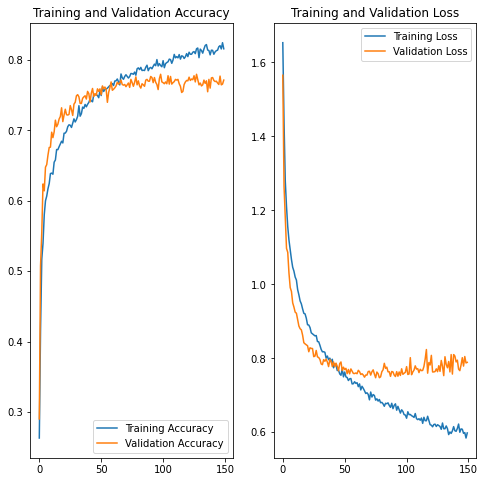

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

31/31 [==============================] - 0s 8ms/step - loss: 0.7889 - accuracy: 0.7716
Test accuracy : 0.7716209292411804


In [16]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/humanModel/model_v0.h5')

In [17]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [18]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [19]:
sunflower_path = "./data/humanModel/imagesDatabase_split/val/39/-MpIqdos7xbOmReSEoMh_10.png"

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(score), 100 * np.max(score))
)

This image most likely belongs to 3 with a 40.46 percent confidence.
